# Exercise4 Report -imdb

## lesson
* lession 3 Multi-label classification, Segmentation

## student
* 20161622 이예은

# IMDB

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# Any edits to libraries you make are reloaded here automatically and any charts or images displayed are shown in this notebook.

In [0]:
from fastai.text import *
#import neccesary library

In [5]:
from fastai.utils.mem import *
free = gpu_mem_get_free_no_cache()
free

15068

## Preparing the data


This data contain reviews on IMDB. 25000 of them are labelled as positive and negative, another 25000 are labelled for testing. The other 50,000 remaning datas are unlablled data.

I will distinguished postive review or negitive review.

In [6]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()
# untar data and and show file names in path 

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

Let's check csv file

In [7]:
df = pd.read_csv(path/'texts.csv')
df.head()
# read csv files

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [8]:
df['text'][1]
# show data text 

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

In [9]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')
# create text data bunch from text.csv

 A text is composed of words, and we can't apply mathematical functions to them directly. So, we have to convert them to numbers. A `TextDataBunch` does tokenization and numericalization.



In [0]:
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [0]:
data = load_data(path)

### Tokenization


**Tokenization** is split the raw sentences into workds, or more exactly tokens.

The way to tokenization
- take care of punctuation
- contractions of two different words, like isn't or don't
- clean some parts of our texts (HTML code for instance )


In [12]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()
#show a batch of data bunch

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

**Numericalization** is converting tokens to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The corresponding from ids to tokens is stored in the `vocab` attribute of our datasets, in a `itos` dictionary.

In [13]:
data.vocab.itos[:10]
# show itos dictinary(for int to string)

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [14]:
data.train_ds[0][0]
# show train data set and see the tokenized text.

Text xxbos xxmaj if you liked watching xxmaj mel xxmaj xxunk in xxmaj million xxmaj dollar xxmaj hotel then you might enjoy watching xxmaj burt xxmaj reynolds in yet another film so bad it could never be distributed . i can only xxunk to the xxup dvd version so maybe the xxup vhs version is better quality wise but the movies night and dark scenes have been so poorly done that xxunk seems red . i first thought my xxup dvd players was messed up . xxmaj it was n't . xxmaj if you xxunk on watching it i recommend you adjust the color on your xxup tv until it is black and white . xxmaj if you do n't you will never be able to get through the film . xxmaj if you do it will simply remind you of a poor film students attempt to xxunk the style of xxmaj pulp xxmaj fiction .

In [15]:
data.train_ds[0][0].data[:10]
# show the underlying numbers data

array([   2,    5,   58,   34,  322,  172,    5, 3743,    5,    0])

### With the data block API


**With the data block API** though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [16]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())
# set get data bunch using data block 

## Language model

**Language model** is predicting the next word given a previous sequence of words

In [0]:
bs=48
#set batch size

Now let's grab the full dataset for what follows.

In [18]:
path = untar_data(URLs.IMDB)
path.ls()
# untar data

[PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/test')]

In [19]:
(path/'train').ls()
# show files in path for train

[PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat')]

* The reviews are in a training and test set following an imagenet structure. The only difference is that there is an unsup folder on top of train and test that contains the unlabelled data.
*  use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. 
* need to adjust the parameters of our model by a little bit because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia.

In [20]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

# creat data bunch that ignores lables

This `TextDataBunch` ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)
# load language model data

In [22]:
data_lm.show_batch()
# show a batch of data

idx,text
0,"unbelievable . xxmaj the only reason i sat through it was because some reviewers said it was so bad it was funny ... xxmaj it was n't , it was painfully bad . xxmaj lame dialogue , direction , acting , story - you name it , it was bad , really bad ! . i going to try and get my money back from the store that rented this"
1,"/ voice off of the characters , but the action is so simple , that makes that reflection a giant xxup joke ! ! xxmaj from the first 10 minutes of the movie , you can fairly guess the end , and found myself predicting a xxunk of the movie . xxmaj however , the whole movie does n't stink , there are parts of imaginary flashbacks from one of"
2,"is thoroughly enjoyable , the constant skips back and forth through time are rather mind - boggling . xxmaj the complex ideas of time travel are interesting and well entwined into the love story . \n \n xxmaj it shows the reality of a relationship between two individuals who have to deal with the negative effects of time travel in a close relationship . \n \n xxmaj actually"
3,"his cast members were there , and he said the movie was made for about $ 40,000 : you certainly ca n't tell that at all . xxmaj this is a film about two brothers who are very different ( played by real - life brothers ) who both find love , but their love lives are complicated by outside circumstances . xxmaj bill xxmaj henderson plays the sentimental and"
4,"up all over the place . xxmaj the mixture needed more stirring . xxmaj the murders are gory , bloody , perverse and it 's hard to watch the crime scenes where the victims are hung up on some contraption with hooks boring into the skin . xxmaj makes your skin crawl when you see it . xxmaj but , they do a very good job of showing this ."


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [23]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
# set language model learner using AWD_LSTM model 
# drop_mult is applied to all the dropouts weights of the config, learn_kwargs are passed to the Learner initialization.

In [0]:
learn.lr_find()
# find learning rate

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


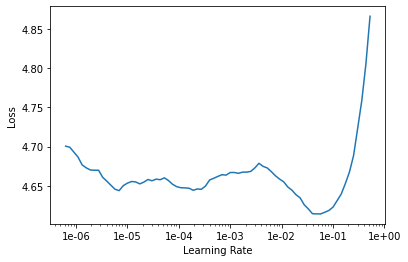

In [0]:
learn.recorder.plot(skip_end=15)
# ploat learning rate graph

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.162229,4.021640,0.295971,59:40


In [0]:
learn.save('fit_head')
# save the model

In [0]:
learn.load('fit_head');
# load the model

Unfeeze and launch a new training.

In [0]:
learn.unfreeze()
# set learn to unfreeze

In [41]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))
# learn 5 cycles 
#moms: momentum

epoch,train_loss,valid_loss,accuracy,time
0,3.861361,3.841840,0.322310,51:19
1,3.846107,3.806089,0.324049,51:21
2,3.792230,3.755900,0.329277,51:19
3,3.698108,3.719289,0.334004,51:17
4,3.628628,3.711794,0.334889,51:18


In [0]:
learn.save('fine_tuned')
# save model

In [0]:
learn.load('fine_tuned');
# load model

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2
# set variable for predicting data

In [46]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))
# print predicting result of these 2 sentencse.

I liked this movie because it was funny . It was funny and enjoyable . It was very entertaining , and there were a few good laughs . But the characters were stereotypical and did n't always make sense . The
I liked this movie because of the Cast 's performance . It was good to see Edie Falco and Anna Paquin in their roles . The scene where Edie asks what kind of life she can see


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [0]:
learn.save_encoder('fine_tuned_enc')
# save encoder

## Classifier

Creating a new data object that only grabs the labelled data and keeps those labels.

In [0]:
path = untar_data(URLs.IMDB)
# set path untart URLs data of IMDB

In [50]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

# Create data bunch
# set create TextList by vocab data
# set labels from 'neg' and 'pos' folders

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
# set data bunch 

In [52]:
data_clas.show_batch()
# show a bach of data

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",pos
"xxbos xxmaj my xxmaj comments for xxup vivah : - xxmaj its a charming , idealistic love story starring xxmaj shahid xxmaj kapoor and xxmaj amrita xxmaj rao . xxmaj the film takes us back to small pleasures like the bride and bridegroom 's families sleeping on the floor , playing games together , their friendly banter and mutual respect . xxmaj vivah is about the sanctity of marriage and",pos
"xxbos xxmaj god ! xxmaj zorro has been the the subject of about as many movies as xxmaj tarzan , and probably had about as many actors in the title role . \n \n xxmaj this xxmaj serial is one of my own personal favourites , and as previously stated , it is one of the xxmaj top 5 xxmaj sound xxmaj serials . xxmaj oddly enough , this",pos
"xxbos xxmaj how strange the human mind is ; this center of activity wherein perceptions of reality are formed and stored , and in which one 's view of the world hinges on the finely tuned functioning of the brain , this most delicate and intricate processor of all things sensory . xxmaj and how much do we really know of it 's inner - workings , of it 's",pos


Try to create a model to classify those reviews and load the encoder we saved before.

In [53]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

# set text_classifier_learner using AWD_LSTM model
# learn.load_encoder : Save the encoder to name inside the model directory.

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj frankly , this movie has gone over the heads of most of its detractors . 
 
  xxmaj the opposite of perdition ( being lost ) is salvation ( being saved ) and this movie is one of a very few to deal with those two concepts . xxmaj the movie also explores the love and disappointments that attend the father - son relationship . xxmaj it should be noted at the outset that none of these are currently fashionable themes . 
 
  xxmaj the premise is that the fathers in the move , hit - man xxmaj michael xxmaj sullivan ( xxmaj tom xxmaj hanks ) and his crime boss xxmaj john xxmaj rooney ( xxmaj paul xxmaj newman ) , love their sons and will do anything to protect them . xxmaj but xxmaj rooney 's son xxmaj connor is even more evil than the rest . xxmaj he kills one of xxmaj rooney 's loyal soldiers to cover up his own stealing from his father . xxmaj when xxmaj connor learns that xxmaj sullivan 's son xxma

In [54]:
learn.lr_find()
# find learning rate

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


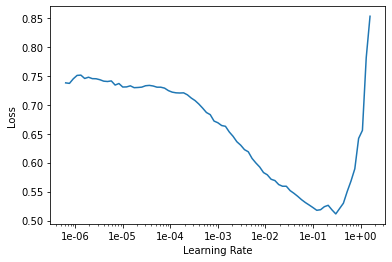

In [55]:
learn.recorder.plot()
# plot graph

In [56]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))
# learn a cycle

epoch,train_loss,valid_loss,accuracy,time
0,0.320999,0.257375,0.897520,08:08


In [0]:
learn.save('first')
# save model

In [0]:
learn.load('first');
# save model

In [59]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

# Freezing layer groups without last 2 layer group
# learn a cycle

epoch,train_loss,valid_loss,accuracy,time
0,0.271969,0.215006,0.914720,09:33


In [0]:
learn.save('second')
# save model

In [0]:
learn.load('second');
# load model

In [62]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
# Freezing layer groups without last 3 layer groups
# learn a cycle

epoch,train_loss,valid_loss,accuracy,time
0,0.232628,0.186829,0.928480,09:05


In [0]:
learn.save('third')
# save model

In [0]:
learn.load('third');
# laod model

In [65]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
# learn using entire model for 2 cycles

epoch,train_loss,valid_loss,accuracy,time
0,0.218456,0.180113,0.929680,09:14
1,0.188768,0.173556,0.932800,07:59


In [66]:
learn.predict("I really loved that movie, it was awesome!")
# predict result of this sentence

(Category pos, tensor(1), tensor([2.8332e-05, 9.9997e-01]))